In [4]:
!pip -q install cma
!pip -q install numba

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
from scipy.special import expit as sigmoid
from pathlib import Path
import seaborn as sns
from scipy.optimize import minimize, fsolve
import cma
from tqdm import tqdm
import glob
data_folder = "../../data/"
COMP_NAME = "g2net-gravitational-wave-detection"
INPUT_PATH = data_folder + f"/{COMP_NAME}/"
OUTPUT_PATH = data_folder +  f"/ensemble-0916/"

In [2]:
import numpy as np 
from numba import jit

@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

In [3]:
def score_oof(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(roc_auc_score(oof["target"], oof[col]),6)
    else:
        scores = [roc_auc_score(df["target"], df[col]) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores),6)
    
def score_oof_fast(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(fast_auc(oof["target"], oof[col]),6)
    else:
        scores = [fast_auc(df["target"], df[col]) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores),6)

In [6]:
oof_best_df = pd.read_csv(data_folder + "/hack-lb/oof_pred_cma_CV0.88307.csv")
oof_best_df
fold_num = 5
pct = 0.16
trial = 5000
target = 0.8840
eps = 5e-5
drop_ids = []
scores = []

for i in range(trial):
    fold_df_samples = []
    for f in range(fold_num):
        fold_df = oof_best_df.query(f"fold=={f}")
        fold_df_sample = fold_df.sample(int(pct * len(fold_df)))
        fold_df_samples.append(fold_df_sample)
    fold_df_sample = pd.concat(fold_df_samples)
    score = fast_auc(fold_df_sample['target'], fold_df_sample['prediction'])
    if abs(score - target) < eps:
        print("{} Score: {:.6f}".format(i, score))
        scores.append(score)
        drop_ids.append(fold_df_sample.id.values)

12 Score: 0.883955
90 Score: 0.883995
181 Score: 0.884015
182 Score: 0.884015
261 Score: 0.883960
274 Score: 0.883969
291 Score: 0.884013
324 Score: 0.883987
337 Score: 0.884005
339 Score: 0.884046
349 Score: 0.884043
405 Score: 0.883956
617 Score: 0.883983
632 Score: 0.883960
706 Score: 0.884005
782 Score: 0.883976
798 Score: 0.884043
1024 Score: 0.883977
1048 Score: 0.884044
1059 Score: 0.884029
1062 Score: 0.884040
1077 Score: 0.884003
1349 Score: 0.883999
1401 Score: 0.883954
1408 Score: 0.883990
1500 Score: 0.883954
1501 Score: 0.884027
1506 Score: 0.884024
1558 Score: 0.883950
1595 Score: 0.883992
1652 Score: 0.883990
1690 Score: 0.883999
1754 Score: 0.883959
1967 Score: 0.883983
2011 Score: 0.883980
2021 Score: 0.884006
2035 Score: 0.884003
2055 Score: 0.884028
2098 Score: 0.884044
2108 Score: 0.884027
2390 Score: 0.883990
2613 Score: 0.883985
2620 Score: 0.883954
2649 Score: 0.884040
2733 Score: 0.883974
2809 Score: 0.884036
2832 Score: 0.884039
2950 Score: 0.884040
3041 Score:

In [7]:
sorted([abs(0.8840-s) for s in scores])

[4.190420708205522e-07,
 1.4200643139172797e-06,
 1.4447520825244808e-06,
 2.733247475350531e-06,
 2.92081002406519e-06,
 3.0832002568814687e-06,
 3.3167004238610076e-06,
 4.43003942707243e-06,
 4.546299410268517e-06,
 5.0254040251385135e-06,
 5.255511883683894e-06,
 5.746875757828285e-06,
 6.0165740034534565e-06,
 6.648738914094565e-06,
 7.5563630311803465e-06,
 7.871372504464347e-06,
 8.177745951631898e-06,
 8.712000732158387e-06,
 8.731975724929342e-06,
 9.560101918104635e-06,
 9.797445413295414e-06,
 1.0039346914014757e-05,
 1.0403284749993524e-05,
 1.0818875810447715e-05,
 1.2977913620759729e-05,
 1.3308250214505435e-05,
 1.4615711055210312e-05,
 1.4936131408793685e-05,
 1.4960491418802846e-05,
 1.5119179450739928e-05,
 1.53745540778516e-05,
 1.6201155219719432e-05,
 1.6509838363321094e-05,
 1.7143936168695362e-05,
 1.7158510240422586e-05,
 1.9679095870861474e-05,
 1.9883549629784447e-05,
 2.1081995591920588e-05,
 2.2505961599028623e-05,
 2.2728333771482312e-05,
 2.316946495728444

In [8]:
len(drop_ids)

87

In [4]:
gt = pd.read_csv(INPUT_PATH + "/" + "training_labels.csv")
names = ["A-RN200","A-B5PL","A-B5","A-V2M","A-1D","A-CWT","A-B3","A-B3CWT",
       "I-B3","I-B4","I-B5","I-B7","I-IV3",
       "R-1D","R-V2SD","R-V2SD2","R-V2","R-V2SDCBAM","R-133",#"R-137",
       "V-V2SD","V_3D",
       "M-1D", "M-1DS32","M-1DC16","M-SD16","M-SD32",
      ]

model_names = ["resnet-200d","eff-B5","eff-b5","ef-v2M","1dCNN","CWT","B3","B3CWT"]
oof_files = [
    "oofs_20210830-191530_CV-0.87733.csv", # ResNet200d
    "oofs_20210918-112751_CV-0.87870.csv", # EfficientNet B5
    "oofs_20210901-130913_CV-0.87749.csv", # EfficientNet B5
    "oofs_20210902-200442_CV-0.87733.csv", # EfficientNet V2 M
    "oofs_20210915-003751_CV-0.87393.csv", # 1D CNN
    "oofs_20210915-072731_CV-0.87707.csv",  # CWT
    "oofs_20210923-103832_CV-0.87829.csv",  # B3
    "oofs_20210925-085935_CV-0.87818.csv",  # B3-CWT
]

oof_paths = [OUTPUT_PATH + "/" + (model_names[i] + "-" + f.split("_")[1]+"_predictions") + "/" + f for i,f in enumerate(oof_files)]
sub_paths = [OUTPUT_PATH  + "/" + (model_names[i] + "-" + f.split("_")[1]+"_predictions") + "/" + f.replace("oofs", "sub") for i,f in enumerate(oof_files)]
#test_paths = [OUTPUT_PATH / (model_names[i] + "-" + f.split("_")[1]+"_predictions") / f.replace("oofs", "test") for i,f in enumerate(oof_files)]

oof_paths_other = [
    OUTPUT_PATH + '/oof_effB3-512-PL-float.csv', 
    OUTPUT_PATH + '/oof_effB4-512-PL-CV087755.csv', 
    OUTPUT_PATH + '/oof_effB5-512-PL-CV087728.csv', 
    OUTPUT_PATH + '/oof_w_effB7-512-SKF.csv', 
    OUTPUT_PATH +  "/oof_inception_v3_PL_CV087466.csv",        
    OUTPUT_PATH +  "/oof_1DCNN_richard.csv",
    OUTPUT_PATH +  "/oof_112nd_V2SD_PL.csv",    
    OUTPUT_PATH + "/oof_121st_V2SD.csv",
    OUTPUT_PATH + "/oof_122nd_V2.csv",
    OUTPUT_PATH + "/oof_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",    
    #OUTPUT_PATH + "/oof_137th_tta_blend.csv",    
    #OUTPUT_PATH +  "/oof_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",        
    OUTPUT_PATH +  "/oof_V2SD_sGW_vflip_sc01_PL_CV88003.csv",        
    #OUTPUT_PATH +  "/oof_resnet34-sGW2ep-PL-sc01_CV87764.csv",   
    OUTPUT_PATH +  "/oof_1D2D_1ep_CV88153.csv",   
    OUTPUT_PATH +  "/oof_1D_adjust_MC_CV88158.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_Split32_MC_CV88149.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_c16_MC_CV88170.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_SD16_MC_CV88164.csv",  
    OUTPUT_PATH +  "/oof_1D_adjust_SD32_MC_CV88185.csv",  
]

sub_paths_other = [
    OUTPUT_PATH + '/submission_effB3-512-PL-CV0877245.csv', 
    OUTPUT_PATH + '/submission_effB4-512-PL-CV087755.csv' ,
    OUTPUT_PATH + '/submission_effB5-512-PL-CV087728.csv', 
    OUTPUT_PATH + '/submission_w_effB7-512-SKF.csv', 
    OUTPUT_PATH +  "/submission_inception_v3_PL_CV087466.csv",        
    OUTPUT_PATH + '/submission_main_35th_GeM_vflip_shuffle01.csv',
    OUTPUT_PATH +  "/submission_112nd_V2SD_PL.csv",
    OUTPUT_PATH + "/submission_121st_V2SD.csv",
    OUTPUT_PATH + "/submission_122nd_V2.csv",
    OUTPUT_PATH + "/submission_124th_V2SDCBAM_tta_blend.csv",
    OUTPUT_PATH + "/submission_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv",    
    #OUTPUT_PATH + "/submission_137th_tta_blend.csv",    
    #OUTPUT_PATH +  "/submission_V2_c16_sGW_vflip_sc01_PL_CV88163.csv",        
    OUTPUT_PATH +  "/submission_V2SD_sGW_vflip_sc01_PL_CV88003.csv",        
    #OUTPUT_PATH +  "/submission_resnet34-sGW2ep-PL-sc01_CV87764.csv",    
    OUTPUT_PATH +  "/submission_1D2D_1ep_CV88153.csv",   
    OUTPUT_PATH +  "/submission_1D_adjust_MC_CV88158.csv",       
    OUTPUT_PATH +  "/submission_1D_adjust_Split32_MC_CV88149.csv",       
    OUTPUT_PATH +  "/submission_1D_adjust_c16_MC_CV88170.csv",  
    OUTPUT_PATH +  "/submission_1D_adjust_SD16_MC_CV88164.csv",  
    OUTPUT_PATH +  "/submission_1D_adjust_SD32_MC_CV88185.csv",  
]

oof_paths.extend(oof_paths_other)
sub_paths.extend(sub_paths_other)

oof_list = [pd.read_csv(p) for p in oof_paths]
sub_list = [pd.read_csv(p) for p in sub_paths]
#test_list = [pd.read_csv(p) for p in test_paths]

oof1 = oof_list[0]
sub1 = sub_list[0]
#test1 = test_list[0]

oof_df = oof1[["id", "target", "fold"]].copy()
for i, oof in enumerate(oof_list):
    if "effB" in oof_paths[i] or 'inception_v3' in oof_paths[i]:
        # oof from Isamu
        oof_df = oof_df.merge(oof[["id","y_pred"]].rename(columns={"y_pred":names[i]}),on=["id"], how='left')
    else:
        oof_df = oof_df.merge(oof[["id","prediction"]].rename(columns={"prediction":names[i]}),on=["id"], how='left')
        
sub_df = sub1[["id"]].copy()
for i, sub in enumerate(sub_list):
    sub_df = sub_df.merge(sub[["id","target"]].rename(columns={"target":names[i]}),on=["id"], how='left')
print("Finish Loading Data")

Finish Loading Data


In [10]:
oof_paths_other

['./input/ensemble-0916//oof_effB3-512-PL-float.csv',
 './input/ensemble-0916//oof_effB4-512-PL-CV087755.csv',
 './input/ensemble-0916//oof_effB5-512-PL-CV087728.csv',
 './input/ensemble-0916//oof_w_effB7-512-SKF.csv',
 './input/ensemble-0916//oof_inception_v3_PL_CV087466.csv',
 './input/ensemble-0916//oof_1DCNN_richard.csv',
 './input/ensemble-0916//oof_112nd_V2SD_PL.csv',
 './input/ensemble-0916//oof_121st_V2SD.csv',
 './input/ensemble-0916//oof_122nd_V2.csv',
 './input/ensemble-0916//oof_124th_V2SDCBAM_tta_blend.csv',
 './input/ensemble-0916//oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05.csv',
 './input/ensemble-0916//oof_V2SD_sGW_vflip_sc01_PL_CV88003.csv',
 './input/ensemble-0916//oof_1D2D_1ep_CV88153.csv',
 './input/ensemble-0916//oof_1D_adjust_MC_CV88158.csv',
 './input/ensemble-0916//oof_1D_adjust_Split32_MC_CV88149.csv',
 './input/ensemble-0916//oof_1D_adjust_c16_MC_CV88170.csv',
 './input/ensemble-0916//oof_1D_adjust_SD16_MC_CV88164.csv',
 './input/ensemble-0916//oof_1D_ad

In [12]:
print("Number of model:", oof_df.shape[1] - 3)

Number of model: 26


In [13]:
oof_rank = oof_df.iloc[:,3:].rank(pct=True)
sub_rank = sub_df.iloc[:,1:].rank(pct=True)

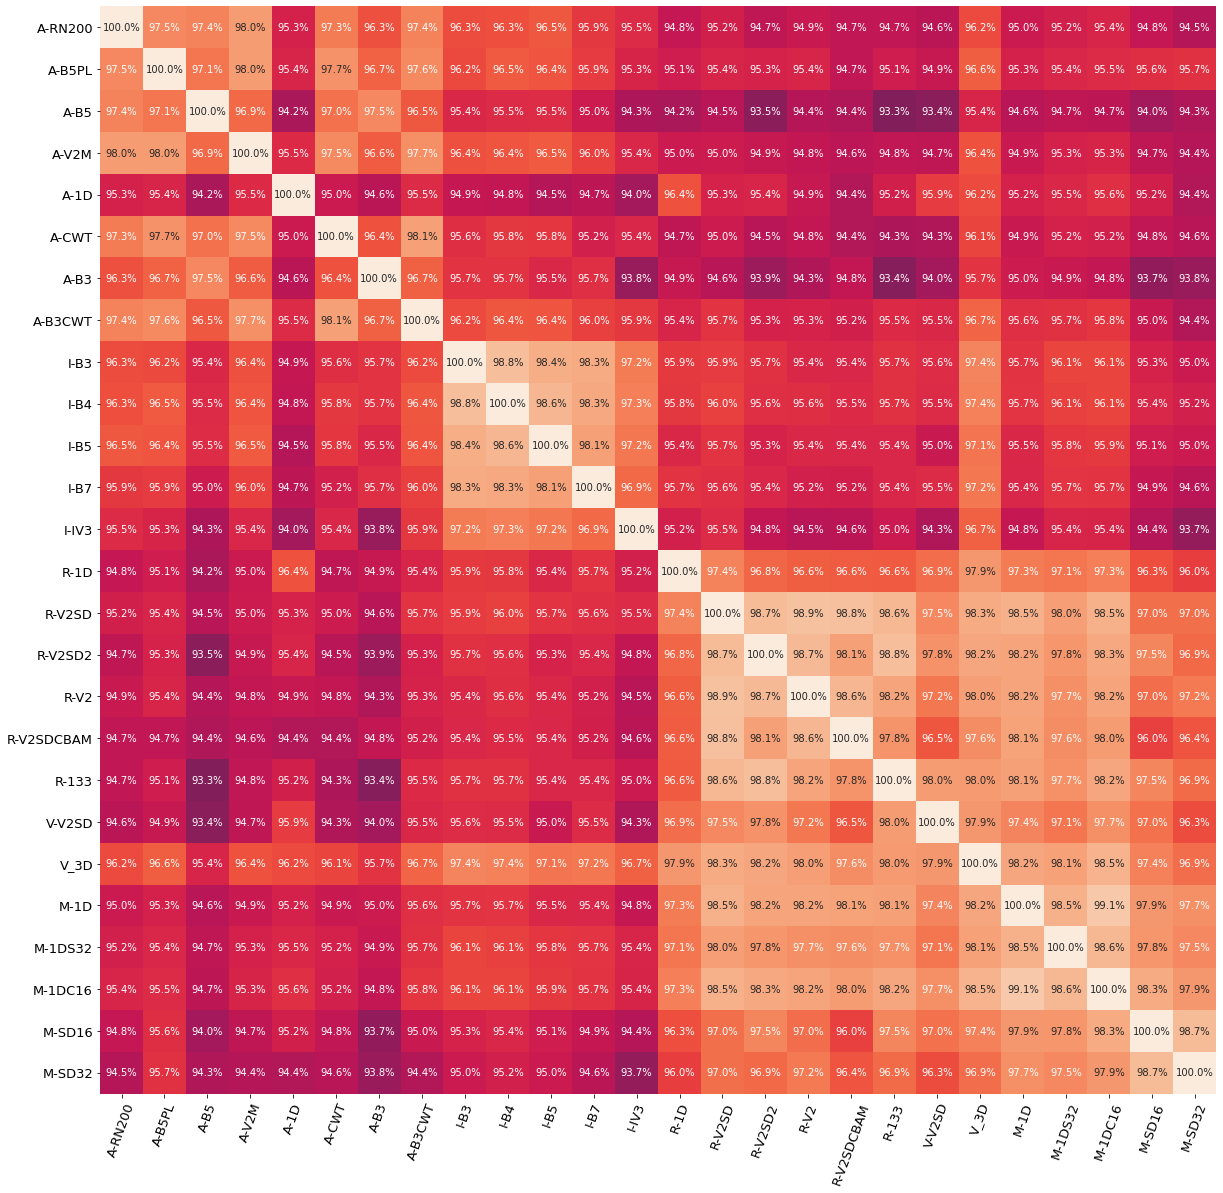

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(oof_rank.corr(), vmin=0.9, vmax=1, annot=True, fmt=".1%",cbar=False);
plt.xticks(size=13,rotation=70)
plt.yticks(size=13)
plt.savefig('corr_rank.jpg')

In [15]:
oof_df.isna().sum(axis=0)

id            0
target        0
fold          0
A-RN200       0
A-B5PL        0
A-B5          0
A-V2M         0
A-1D          0
A-CWT         0
A-B3          0
A-B3CWT       0
I-B3          0
I-B4          0
I-B5          0
I-B7          0
I-IV3         0
R-1D          0
R-V2SD        0
R-V2SD2       0
R-V2          0
R-V2SDCBAM    0
R-133         0
V-V2SD        0
V_3D          0
M-1D          0
M-1DS32       0
M-1DC16       0
M-SD16        0
M-SD32        0
dtype: int64

In [16]:
{names[i]: ".".join(path.split("/")[-1].split(".")[:-1]) for i, path in enumerate(oof_paths)}

{'A-RN200': 'oofs_20210830-191530_CV-0.87733',
 'A-B5PL': 'oofs_20210918-112751_CV-0.87870',
 'A-B5': 'oofs_20210901-130913_CV-0.87749',
 'A-V2M': 'oofs_20210902-200442_CV-0.87733',
 'A-1D': 'oofs_20210915-003751_CV-0.87393',
 'A-CWT': 'oofs_20210915-072731_CV-0.87707',
 'A-B3': 'oofs_20210923-103832_CV-0.87829',
 'A-B3CWT': 'oofs_20210925-085935_CV-0.87818',
 'I-B3': 'oof_effB3-512-PL-float',
 'I-B4': 'oof_effB4-512-PL-CV087755',
 'I-B5': 'oof_effB5-512-PL-CV087728',
 'I-B7': 'oof_w_effB7-512-SKF',
 'I-IV3': 'oof_inception_v3_PL_CV087466',
 'R-1D': 'oof_1DCNN_richard',
 'R-V2SD': 'oof_112nd_V2SD_PL',
 'R-V2SD2': 'oof_121st_V2SD',
 'R-V2': 'oof_122nd_V2',
 'R-V2SDCBAM': 'oof_124th_V2SDCBAM_tta_blend',
 'R-133': 'oof_133rd_V2SD_PL_4ep_2em3lr_32ch_vf_sc01_drop05',
 'V-V2SD': 'oof_V2SD_sGW_vflip_sc01_PL_CV88003',
 'V_3D': 'oof_1D2D_1ep_CV88153',
 'M-1D': 'oof_1D_adjust_MC_CV88158',
 'M-1DS32': 'oof_1D_adjust_Split32_MC_CV88149',
 'M-1DC16': 'oof_1D_adjust_c16_MC_CV88170',
 'M-SD16': 'oof_

In [17]:
oof_df.head()

,id,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00000e74ad,1,3,-0.351255,-0.522575,-0.033018,-0.152198,-0.841736,-0.347086,-0.208484,...,0.307355,0.427559,0.255428,0.360444,0.373976,0.360875,0.371726,0.336293,0.327337,0.298945
1,00001f4945,0,0,-0.803476,-1.338088,-1.106954,-0.725166,-1.709305,-1.180710,-1.225705,...,0.101910,0.112691,0.104326,0.118170,0.099576,0.106059,0.123024,0.099103,0.114302,0.099525
2,0000661522,0,4,-1.121866,-1.507696,-1.106752,-1.140151,-1.570441,-1.062900,-1.160880,...,0.161061,0.192216,0.188557,0.198105,0.129473,0.204139,0.126147,0.166569,0.159226,0.199106
3,00007a006a,0,0,-1.295713,-1.526156,-1.164980,-1.197089,-1.090511,-1.212057,-1.370953,...,0.101480,0.102064,0.130833,0.135400,0.117951,0.155885,0.153501,0.127285,0.136019,0.114051
4,0000a38978,1,4,-0.233715,-0.393928,-0.257395,0.126759,-1.130708,-0.315936,-0.620537,...,0.246235,0.303882,0.268977,0.290217,0.250171,0.284270,0.259535,0.230736,0.349107,0.457787


In [18]:
sub_df.head()

,id,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,I-B3,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
0,00005bced6,2.101307,2.408690,2.269970,2.290631,3.007926,2.265291,2.288800,2.101119,0.998701,...,0.999747,0.999962,0.999971,0.999833,0.999944,0.999543,0.999769,0.999699,0.999302,0.998848
1,0000806717,1.514980,1.710782,1.526297,1.593227,1.630305,1.380817,1.237861,0.926948,0.903440,...,0.915381,0.956749,0.907443,0.909374,0.951770,0.957589,0.965001,0.951319,0.949645,0.924419
2,0000ef4fe1,-0.669418,-0.838041,-0.598816,-0.475593,-0.898371,-0.664295,-0.820795,-1.002344,0.229692,...,0.232941,0.244787,0.239195,0.305708,0.219522,0.251602,0.262339,0.262544,0.298552,0.287797
3,00020de251,1.280244,1.573700,1.490624,1.264398,1.089086,1.525732,0.952786,1.033834,0.761568,...,0.937249,0.979087,0.928078,0.853633,0.908216,0.964059,0.979279,0.959553,0.967139,0.951196
4,00024887b5,-1.376278,-1.757232,-1.403377,-1.430901,-2.033942,-1.442704,-1.653411,-1.793073,0.158145,...,0.053091,0.050590,0.061209,0.086943,0.064644,0.076858,0.068511,0.077224,0.099398,0.086851


In [19]:
oof_df.describe()

,target,fold,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,...,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000
mean,0.499875,2.000000,0.046828,-0.058198,0.106662,0.101230,0.036813,0.065030,-0.119318,-0.238042,...,0.446232,0.453965,0.450615,0.467862,0.452312,0.460126,0.481366,0.487934,0.505703,0.489330
std,0.500000,1.414215,1.481512,1.726563,1.685370,1.497658,2.043871,1.502482,3.167510,1.583683,...,0.385009,0.386274,0.381813,0.360484,0.379084,0.379492,0.363063,0.358679,0.348692,0.350731
min,0.000000,0.000000,-2.612311,-2.920961,-36.039394,-2.466414,-3.281515,-2.409353,-2.730645,-2.763245,...,0.009655,0.009439,0.016804,0.018401,0.014317,0.016653,0.013040,0.019282,0.027650,0.028851
25%,0.000000,1.000000,-1.148762,-1.457553,-1.134825,-1.116461,-1.618619,-1.129007,-1.415669,-1.473963,...,0.103551,0.106535,0.110501,0.152991,0.117002,0.128182,0.169842,0.182117,0.201784,0.192716
50%,0.000000,2.000000,-0.542804,-0.758978,-0.505731,-0.501343,-0.796667,-0.525964,-0.773762,-0.847536,...,0.262015,0.272559,0.268920,0.319863,0.276226,0.270287,0.292222,0.298627,0.335655,0.302295
75%,1.000000,3.000000,1.659993,1.922530,1.795110,1.860344,1.987943,1.790570,1.564970,1.447580,...,0.969253,0.980589,0.971551,0.938428,0.967296,0.982787,0.991222,0.991854,0.989942,0.983396
max,1.000000,4.000000,7.474235,109.516266,241.051575,26.659441,5.508315,42.650219,590.999146,68.140289,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
sub_df.describe()

,A-RN200,A-B5PL,A-B5,A-V2M,A-1D,A-CWT,A-B3,A-B3CWT,I-B3,I-B4,...,R-V2,R-V2SDCBAM,R-133,V-V2SD,V_3D,M-1D,M-1DS32,M-1DC16,M-SD16,M-SD32
count,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,...,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000
mean,-0.013878,-0.130381,0.044970,0.039600,-0.046625,0.004683,-0.189549,-0.306090,0.473161,0.487229,...,0.429710,0.448581,0.433880,0.452480,0.435771,0.443270,0.465290,0.472138,0.490581,0.474341
std,1.453328,1.667306,1.573125,1.467607,2.005636,1.455384,2.160146,1.507303,0.343080,0.338824,...,0.379178,0.381243,0.375714,0.353681,0.374158,0.374207,0.357628,0.353460,0.342611,0.342324
min,-2.485015,-2.579532,-2.308764,-2.208016,-3.021012,-2.192105,-2.490708,-2.585276,0.052723,0.055773,...,0.011923,0.011414,0.016183,0.023444,0.015365,0.019546,0.030344,0.041206,0.052687,0.049810
25%,-1.165660,-1.475116,-1.154036,-1.132633,-1.633426,-1.142866,-1.437398,-1.493855,0.185519,0.199050,...,0.101785,0.109355,0.109335,0.151680,0.113506,0.125228,0.167230,0.179526,0.200057,0.191329
50%,-0.599527,-0.831122,-0.573852,-0.558589,-0.872813,-0.587209,-0.857699,-0.915538,0.309953,0.334033,...,0.243203,0.271034,0.249772,0.302380,0.256699,0.252404,0.277704,0.283967,0.322215,0.297375
75%,1.512126,1.759078,1.674070,1.621865,1.652125,1.551509,1.339853,1.223311,0.925433,0.935325,...,0.931051,0.966499,0.931465,0.876134,0.930001,0.960864,0.968134,0.974700,0.963867,0.935114
max,7.742320,31.386963,65.547010,16.921555,5.073774,20.982845,139.015530,20.821293,0.999209,0.999533,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


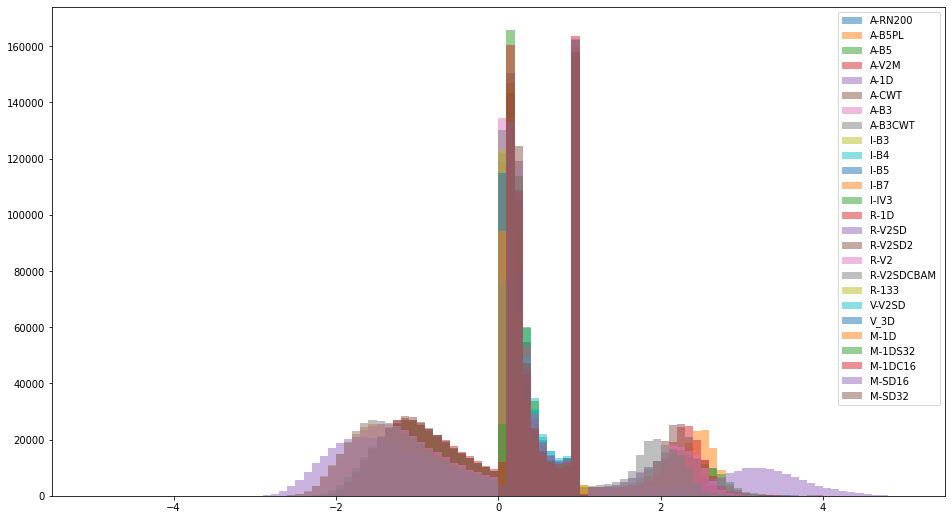

In [21]:
plt.figure(figsize=(16,9))
for o in oof_df.columns[3:]:
    plt.hist(oof_df[o], bins=100, alpha=0.5, range=[-5, 5], label=o)
plt.legend(loc='upper right');

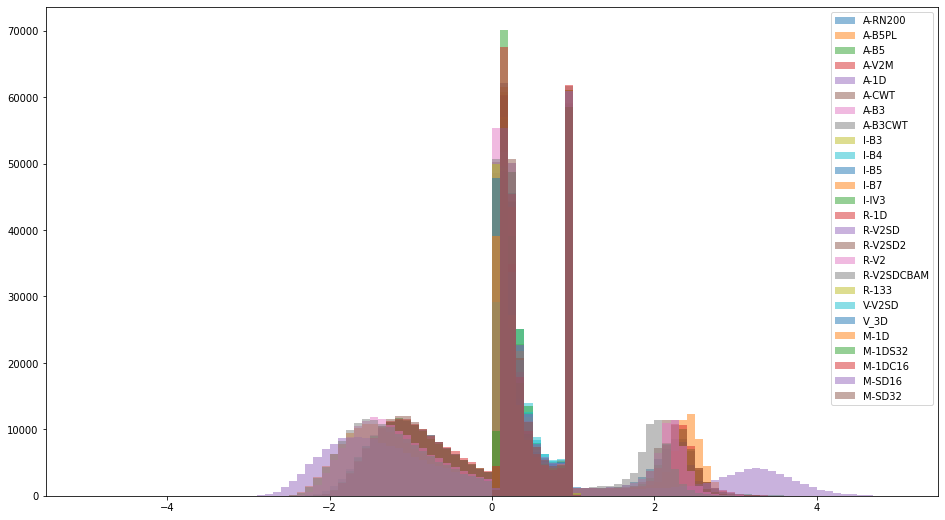

In [22]:
plt.figure(figsize=(16,9))
for s in sub_df.columns[1:]:
    plt.hist(sub_df[s], bins=100, alpha=0.5, range=[-5, 5], label=s)
plt.legend(loc='upper right');

# Sum, rank & power ensemble

In [23]:
oof_score = pd.DataFrame(columns=[f"fold_{i}" for i in range(5)])
for i, col in enumerate(oof_df.columns[3:]):
    oof_score.loc[col,:] = score_oof_fast(oof_df, col=col, get_list=True)
oof_score["Mean_AUC"] = oof_score.mean(axis=1)
oof_score = oof_score.astype(float)

In [24]:
oof_score.style.format("{:.5f}").background_gradient(axis=0)

,fold_0,fold_1,fold_2,fold_3,fold_4,Mean_AUC
A-RN200,0.87810,0.87623,0.87681,0.87828,0.87723,0.87733
A-B5PL,0.87946,0.87784,0.87807,0.87951,0.87861,0.87870
A-B5,0.87838,0.87620,0.87677,0.87839,0.87772,0.87749
A-V2M,0.87815,0.87666,0.87636,0.87813,0.87736,0.87733
A-1D,0.87435,0.87297,0.87336,0.87505,0.87391,0.87393
A-CWT,0.87766,0.87615,0.87662,0.87776,0.87713,0.87707
A-B3,0.87939,0.87756,0.87779,0.87812,0.87858,0.87829
A-B3CWT,0.87908,0.87746,0.87751,0.87876,0.87809,0.87818
I-B3,0.87810,0.87656,0.87643,0.87866,0.87682,0.87731
I-B4,0.87821,0.87692,0.87685,0.87877,0.87716,0.87758


In [25]:
avg_auc = oof_score.mean(axis=1).mean()

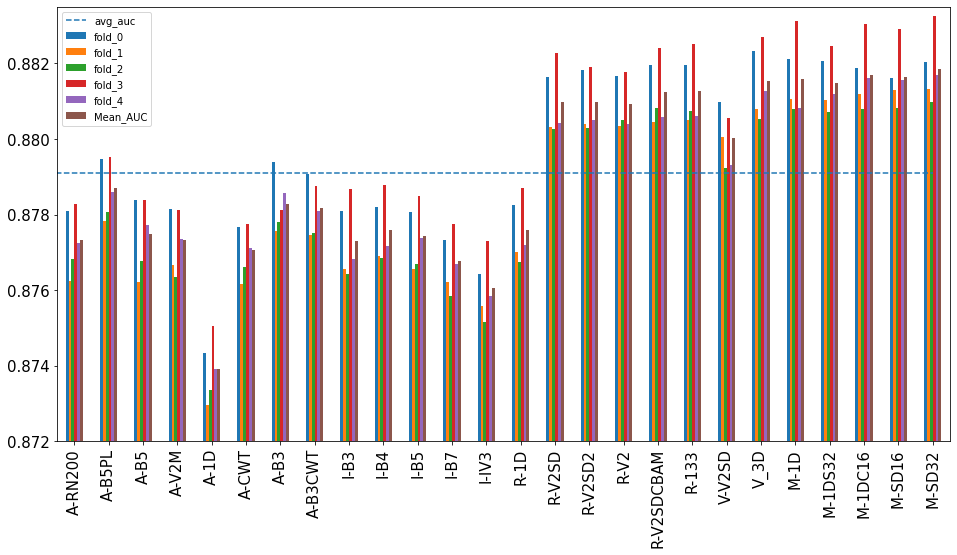

In [26]:
oof_score.plot(kind='bar',figsize=(16,8))
plt.ylim(0.8720,0.8835)
plt.xticks(size=15)
plt.yticks(size=15)
plt.hlines(y=avg_auc,xmin=-1, xmax=25, linestyles="--", label="avg_auc")
plt.legend()
plt.show()

In [27]:
pre_method = "logit"
clip = 20
eps = 1e-9
for i, col in enumerate(oof_df.columns[3:]):
    if pre_method == 'rank':
        oof_df[col] = oof_df[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    elif pre_method == 'rank-power2':
        oof_df[col] = oof_df[col].rank(pct=True) ** 2
        sub_df[col] = sub_df[col].rank(pct=True) ** 2
    elif pre_method == 'rank-fold':
        oof_df[col] = oof_df.groupby('fold')[col].rank(pct=True)
        sub_df[col] = sub_df[col].rank(pct=True)
    elif pre_method == 'logit':
        if oof_df[col].max() > 1:
            oof_df[col] = np.clip(oof_df[col], -clip, clip)
            sub_df[col] = np.clip(sub_df[col], -clip, clip)
            pass
        else:
            oof_df[col] =  np.log(oof_df[col]) - np.log(1-oof_df[col]+eps)
            sub_df[col] = np.log(sub_df[col]) - np.log(1-sub_df[col]+eps)
    elif pre_method == "prob":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            continue
        else:
            oof_df[col] = np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))
            sub_df[col] = np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))
    elif pre_method == "prob**2":
        if oof_df[col].max() <= 1 and oof_df[col].min() >= 0:
            oof_df[col] = oof_df[col] ** 2
            sub_df[col] = sub_df[col] ** 2
        else:
            oof_df[col] = (np.exp(oof_df[col]) / (1 + np.exp(oof_df[col]))) ** 2
            sub_df[col] = (np.exp(sub_df[col]) / (1 + np.exp(sub_df[col]))) ** 2

/home/vincentwang/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
if pre_method == "rank-fold":
    for i, col in enumerate(oof_df.columns[3:]):
        print(col," : ",score_oof(oof_df, col=col), score_oof(oof_df, col=col, full=True))

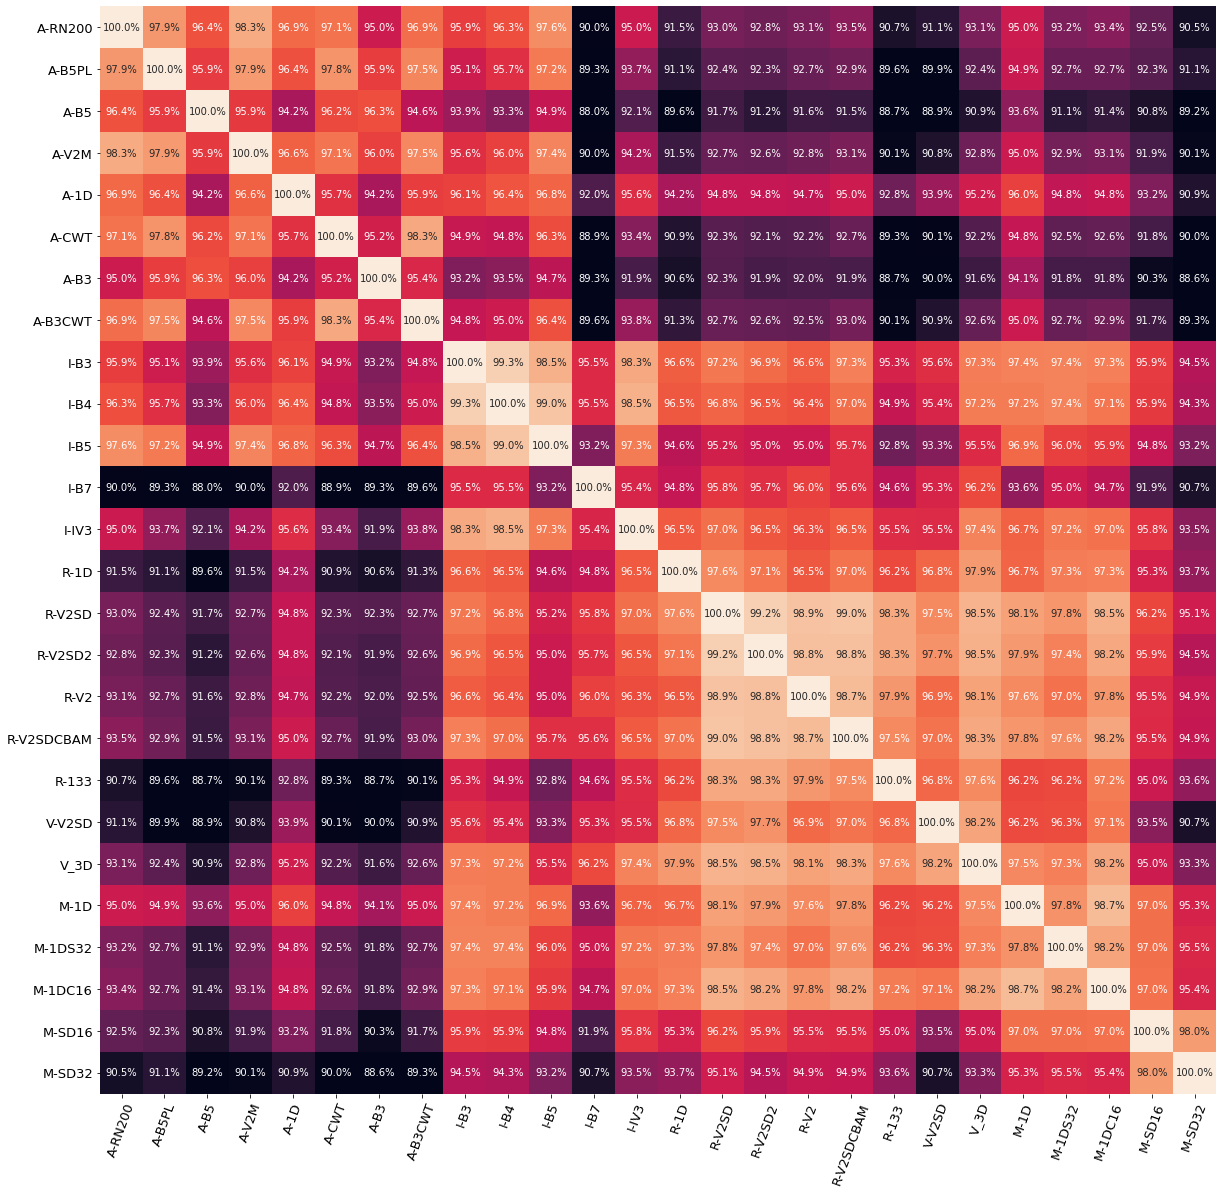

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(oof_df.iloc[:,3:].corr(), vmin=0.9, vmax=1, annot=True, fmt=".1%",cbar=False);
plt.xticks(size=13,rotation=70)
plt.yticks(size=13)
plt.savefig('corr.jpg')

In [30]:
# def plot_fold_distribution(fold_groups, col, ax, lb_score=None):
#     for name, group in fold_groups:
#         group[col].hist(bins=100,alpha=0.4, ax=ax, label=name)
#     ax.set_title(f"{col}, Mean AUC {score_oof(oof_df, col=col):.4f}, OOF AUC {score_oof(oof_df, col=col,full=True):.4f}, LB {lb_score}",size=12)
#     ax.legend()

# # check oof-13 and oof-14 distribution
# fig,axes = plt.subplots(1,2,figsize=(16,6))
# fold_groups = oof_df.groupby("fold")
# plot_fold_distribution(fold_groups, 'oof-13', axes[0], lb_score=0.8828)
# plot_fold_distribution(fold_groups, 'oof-14', axes[1], lb_score=0.8825)
# plt.show()

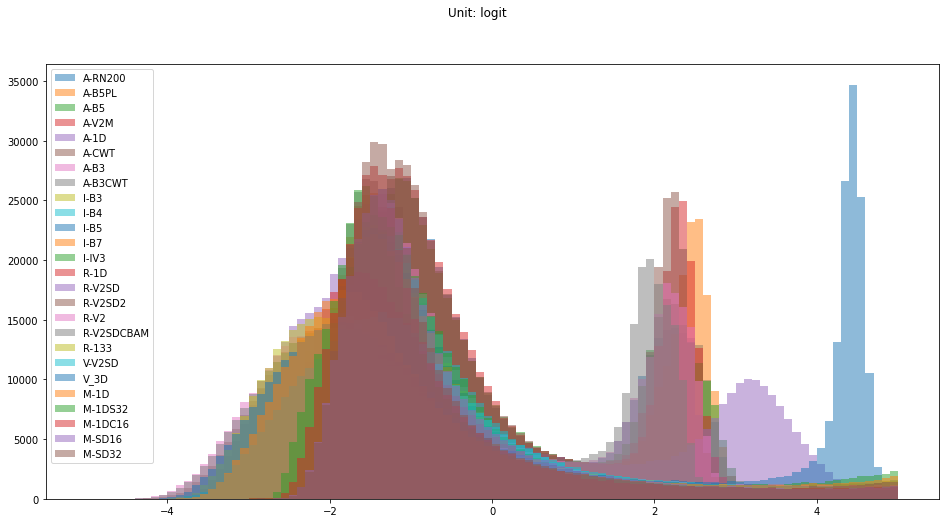

In [31]:
plt.figure(figsize=(16,8))
for o in oof_df.columns[3:]:
    if pre_method == "logit":
        plt.hist(oof_df[o], bins=100, alpha=0.5, range=[-5, 5], label=o)
    else:
        plt.hist(oof_df[o], bins=100, alpha=0.5, label=o)
plt.suptitle(f"Unit: {pre_method}")
plt.legend(loc='upper left');

# Sum Prediction

In [32]:
sum_preds = oof_df.copy()
sum_preds["prediction"] = 0

for col in oof_df.columns[3:]:
    sum_preds["prediction"] += sum_preds[col]
    
print(score_oof(sum_preds), score_oof(sum_preds,True))

0.882617 0.882552


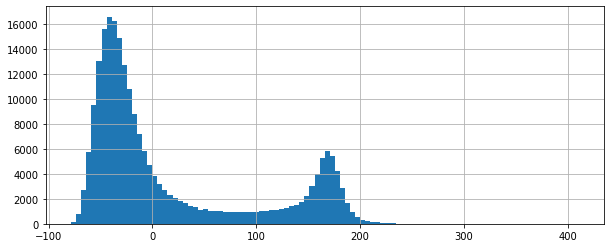

In [33]:
# Make a summed submission
sub_sum = sub_df[['id']].copy()
sub_sum['target'] = np.sum(sub_df.iloc[:,1:],axis=1)
sub_sum["target"].hist(bins=100,figsize=(10,4))
#sub_sum.to_csv(f"./summed_ensemble_{score_oof(sum_preds):0.5f}.csv", index=False)

# Power Prediction

In [34]:
for power in [0.25, 0.5, 1.5, 2, 4, 8]:
    pow_preds = oof_df.copy()
    pow_preds["prediction"] = 0
    for col in oof_df.columns[3:]:
        if pre_method == "logit":
            # to probability
            pow_preds[col] = np.exp(pow_preds[col])/(1+np.exp(pow_preds[col])) 
        pow_preds["prediction"] += pow_preds[col] ** power    
    print(f"{power:0.1f}, {score_oof(pow_preds):0.6f}, {score_oof(pow_preds,True):.6f}")

# power = 0.5
# pow_preds = oof1.copy()
# pow_preds["prediction"] = 0
# for o in oof_list:
#     pow_preds["prediction"] += sigmoid(o["prediction"]) ** power

0.2, 0.882552, 0.882487
0.5, 0.882552, 0.882489
1.5, 0.882512, 0.882450
2.0, 0.882475, 0.882412
4.0, 0.882276, 0.882202
8.0, 0.881862, 0.881764


# Scipy Optimization

In [35]:
# %%time
# sci_opt_preds = oof_df.copy() 
# model_cols = oof_df.columns[3:]
# X = sci_opt_preds[model_cols].values
# print(model_cols, sci_opt_preds.shape)
# def get_score(weights, oof=sci_opt_preds):
#     weights = np.array(weights)
#     sci_opt_preds["prediction"] = (weights * X).sum(axis=1)
#     return -score_oof_fast(sci_opt_preds)

# tol = 1e-10
# init_guess = [1 / len(model_cols)] * len(model_cols)
# bnds = [(-1, 1) for _ in range(len(model_cols))]
# print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
# res_scipy = minimize(fun = get_score, 
#                     x0 = init_guess, 
#                     method = 'Nelder-Mead', 
#                     bounds = bnds, 
#                     tol = tol)
# print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
# sci_cv_score = -res_scipy.fun
# print('-' * 70)
# for n, key in enumerate(model_cols):
#     print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
# ws = res_scipy.x 
# ws = ws / np.sum(ws) # The nelder-mead method requires normalization because the sum of the weights does not equal 1.
# pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

In [36]:
# res_scipy.x 

In [37]:
# sci_opt_preds["prediction"] = np.sum(ws * sci_opt_preds[model_cols],axis=1)
# sci_opt_preds[["id","target","fold","prediction"]].to_csv(f"./oof_pred_sci_CV{sci_cv_score:.5f}.csv",index=False)

In [38]:
# sci_opt_preds.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['prediction']))

In [39]:
# sci_opt_preds.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['prediction'])).mean()

In [40]:
# sub_sci = sub_df[['id']].copy()
# sub_sci['target'] = np.sum(sub_df.iloc[:,1:] * ws,axis=1)
# sub_sci.to_csv(f"./sci_ensemble_{sci_cv_score:0.5f}.csv", index=False)
# sub_sci["target"].hist(bins=100,figsize=(10,4));

# CMA-ES

In [101]:
def plot_weight(model_cols, ws, title):
    pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))
    plt.yticks(size=15)
    plt.xticks(size=15)
    plt.title(title, size=15)
    plt.show()


def getCMA_weight(oof_df, plot=False):
    cma_opt_preds = oof_df.copy()
    model_cols = oof_df.columns[3:]
    X = cma_opt_preds[model_cols].values
    print(model_cols, cma_opt_preds.shape)
    
    def get_score(weights, oof=cma_opt_preds, X=X):
        weights = np.array(weights)
        oof["prediction"] = (weights * X).sum(axis=1)
        return -score_oof(oof)


    init_guess = [1 / len(model_cols)] * len(model_cols)
    print("Inital Blend OOF: {:.6f}".format(-get_score(init_guess)))

    es = cma.CMAEvolutionStrategy(init_guess, 0.5, {'seed': 2021, "bounds": [None, None]})
    es.optimize(get_score, verb_disp=False)
    print(es.result_pretty())
    print("Optimised Blend OOF: {:.6f}".format(-get_score(es.result.xbest)))

    ws = es.result.xbest
    ws = np.array(ws) 
    ws = ws/ sum(ws)
    cma_cv_score = -get_score(ws)
    if plot:
        plot_weight(model_cols, ws, title="Score {:.7f}".format(cma_cv_score))
    return ws, cma_cv_score

In [102]:
from time import sleep
from joblib import Parallel, delayed
import numpy as np
import numpy

In [103]:
use_hack = True
num_hack = 40
if use_hack:
    wss = []
    cma_cv_scores = []
    low_diff_scores = sorted([abs(0.8840-s) for s in scores])[:num_hack]
    drop_ids_selected = [drop_ids[i] for i,s in enumerate(scores) if abs(0.8840-s) in low_diff_scores]
    def hack(i):
        drop_id = drop_ids_selected[i]
        oof_df_hack = oof_df.query(f"id not in {list(drop_id)}")
        ws, cma_cv_score= getCMA_weight(oof_df_hack)        
        return ws, cma_cv_score
    
    for i in tqdm(range(0, len(drop_ids_selected),10)):        
        res = Parallel(n_jobs=10, verbose=0)(delayed(hack)(i) 
                                              for i in range(i,i+min(10, len(drop_ids_selected)-i))
                                             )
        for j in range(len(res)):
            wss.append(res[j][0])
            cma_cv_scores.append(res[j][1])
else:
    ws,cma_cv_score = getCMA_weight(oof_df)    

 75%|███████████████████████████████████████████████████                 | 3/4 [58:07<19:30, 1170.57s/it]

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882371
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:34 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828460e-01 -8.828470e-01
incumbent solution: [ 2.49976082  4.16224488  1.22428383 -0.93038268 -2.36040494 -2.53876446
  4.99661077  2.14254256 ...]
std deviations: [0.12826664 0.14188002 0.12424493 0.12613338 0.1094502  0.13401882
 0.14295253 0.12847362 ...]
CMAEvolutionStrategyResult(xbest=array([ 2.73453054,  4.28323238,  1.26200533, -0.82674579, -2.23320312,
       -2.64870625,  4.42767561,  2.19887556, -1.14379704,  0.10991193,
        2.1249568 ,  1.62463434, -0.50513404, -0.39026299, -2.87918074,
        

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882353
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:15 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828350e-01 -8.828350e-01
incumbent solution: [ 3.28466153 10.81172024  4.34540627 -1.93253779 -5.38757781 -4.64386141
  8.40717726  4.9092854  ...]
std deviations: [0.16207348 0.20805056 0.17010282 0.16861822 0.14185435 0.1694581
 0.20214255 0.16657957 ...]
CMAEvolutionStrategyResult(xbest=array([ 2.95344595,  9.9026654 ,  3.62903547, -1.18537643, -4.97428429,
       -4.40315373,  8.96515736,  3.9265837 , -1.45780402, -1.73699763,
        4.52722617,  4.29620683, -1.26035676, -1.95417879, -6.23127513,
        2

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882361
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:16 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828140e-01 -8.828140e-01
incumbent solution: [ 3.68742381 14.18998011  6.55383985 -1.55973802 -6.7471045  -8.80430398
 12.5028589   7.57205116 ...]
std deviations: [0.30695237 0.3399058  0.33022414 0.2728174  0.27487936 0.33377818
 0.32266458 0.32929133 ...]
CMAEvolutionStrategyResult(xbest=array([ 4.2545104 , 12.94521952,  6.98457412, -0.48197511, -5.6055681 ,
       -9.58132897, 11.98837278,  7.1794741 , -3.11152258, -1.34424946,
        5.99643699,  5.27760434,  2.1414367 , -3.59427144, -9.4566515 ,
        

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882386
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:28 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828390e-01 -8.828390e-01
incumbent solution: [ 2.62503592 13.85780321  4.44618209 -0.69133341 -6.47156889 -8.73708827
 12.15035524  9.29822196 ...]
std deviations: [0.3755222  0.44711097 0.34767733 0.35913285 0.32064383 0.38933235
 0.43117422 0.39233269 ...]
CMAEvolutionStrategyResult(xbest=array([ 3.26100949, 11.66474648,  4.60682065, -0.7690178 , -6.36816625,
       -6.63308124, 11.6422079 ,  8.57230423, -1.96687876, -3.39462881,
        5.44553977,  6.91096401,  1.13211353, -1.49541199, -7.1316752 ,
        

Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882357
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:30 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828120e-01 -8.828130e-01
incumbent solution: [ 2.02579657  6.07209222  1.6626895  -0.98414992 -2.82641502 -3.25139708
  6.14228447  2.24795878 ...]
std deviations: [0.12258259 0.14702306 0.12300332 0.13428018 0.10888777 0.13350732
 0.15926249 0.12856464 ...]
CMAEvolutionStrategyResult(xbest=array([ 2.08849026,  6.03335867,  1.42992335, -0.86181284, -2.89515532,
       -3.12403989,  5.97186264,  2.30142728, -0.72571979, -0.20129449,
        2.15117721,  2.46080543, -0.04303232, -0.92070986, -4.06170496,
        

100%|██████████████████████████████████████████████████████████████████| 4/4 [1:17:19<00:00, 1159.89s/it]


In [104]:
cv_weight = np.array([ 4.63385156, 10.67131254,  4.04905657, -1.81339161, -5.93698257,
       -5.9930177 , 10.71988533,  6.37136265, -1.15393876, -1.92624547,
        4.2712527 ,  4.94285969,  0.36318843, -2.0695388 , -7.22271966,
        3.01667661,  7.19567808, 10.75450191, -0.28426664,  0.22646093,
        3.53155457,  5.70325588, 10.78519968,  2.78969157,  7.09653691,
       21.85890412])
cv_weight = cv_weight / np.sum(cv_weight)

weights_df = pd.DataFrame(wss, index=[f"hack_{i}" for i in range(len(wss))], columns=oof_df.columns[3:]).T
weights_df["hack_avg"] = weights_df.mean(axis=1)
weights_df['allCV'] = cv_weight
weights_df.style.format("{:.1%}").background_gradient(axis=0)

,hack_0,hack_1,hack_2,hack_3,hack_4,hack_5,hack_6,hack_7,hack_8,hack_9,hack_10,hack_11,hack_12,hack_13,hack_14,hack_15,hack_16,hack_17,hack_18,hack_19,hack_20,hack_21,hack_22,hack_23,hack_24,hack_25,hack_26,hack_27,hack_28,hack_29,hack_30,hack_31,hack_32,hack_33,hack_34,hack_35,hack_36,hack_37,hack_38,hack_39,hack_avg,allCV
A-RN200,3.8%,3.6%,2.9%,5.1%,4.6%,3.7%,4.1%,3.0%,4.4%,6.9%,2.9%,4.0%,5.3%,5.1%,4.7%,6.2%,5.1%,3.2%,4.5%,6.6%,3.4%,4.3%,3.3%,4.0%,4.6%,5.4%,4.6%,6.0%,6.0%,4.8%,3.9%,1.6%,1.9%,5.2%,5.1%,5.2%,3.5%,4.6%,4.1%,3.7%,4.4%,5.0%
A-B5PL,12.7%,11.1%,16.1%,12.0%,14.5%,14.6%,7.9%,10.8%,12.7%,10.8%,8.9%,11.1%,9.4%,12.6%,9.0%,11.8%,13.8%,13.5%,14.2%,10.7%,11.3%,13.9%,12.2%,10.2%,11.0%,13.5%,10.6%,10.2%,10.7%,13.0%,12.0%,11.6%,15.1%,13.3%,11.7%,10.7%,12.9%,11.6%,10.2%,12.0%,11.9%,11.5%
A-B5,4.7%,6.0%,3.4%,5.5%,4.9%,6.6%,4.9%,4.3%,3.0%,3.2%,5.2%,6.1%,4.2%,4.1%,4.0%,1.6%,3.4%,3.3%,3.8%,4.5%,4.1%,2.4%,5.3%,6.2%,2.5%,4.0%,4.2%,3.9%,5.2%,4.3%,5.0%,4.6%,3.6%,5.2%,5.5%,2.9%,5.3%,4.9%,5.0%,3.3%,4.3%,4.4%
A-V2M,-1.5%,-0.4%,-1.5%,-2.2%,-0.6%,-2.1%,-0.3%,-0.7%,-1.8%,-2.1%,0.6%,-0.2%,0.6%,-1.1%,0.7%,-2.9%,-1.9%,-0.1%,-2.6%,-4.1%,-2.5%,-0.3%,-1.5%,-1.0%,0.8%,-1.8%,-0.5%,-2.6%,-4.1%,-2.0%,-2.5%,-0.3%,0.6%,-0.7%,0.2%,-1.2%,-2.5%,-1.5%,-0.0%,-0.6%,-1.2%,-2.0%
A-1D,-6.4%,-4.8%,-5.1%,-6.5%,-4.9%,-5.9%,-4.9%,-5.9%,-6.1%,-5.6%,-5.2%,-6.5%,-5.4%,-7.5%,-5.1%,-6.0%,-6.4%,-6.2%,-6.1%,-4.5%,-6.6%,-4.9%,-7.5%,-5.4%,-6.0%,-4.7%,-6.7%,-5.3%,-6.6%,-6.3%,-5.5%,-5.2%,-6.0%,-6.1%,-4.4%,-5.3%,-6.8%,-5.7%,-5.1%,-6.6%,-5.8%,-6.4%
A-CWT,-5.7%,-8.2%,-8.1%,-5.5%,-8.1%,-6.9%,-6.5%,-6.2%,-6.6%,-6.7%,-7.5%,-7.7%,-5.1%,-7.5%,-9.2%,-4.9%,-7.1%,-6.8%,-6.3%,-6.0%,-5.3%,-5.4%,-8.1%,-7.0%,-6.3%,-7.9%,-8.2%,-9.4%,-5.6%,-5.6%,-6.3%,-6.5%,-7.6%,-6.7%,-5.6%,-5.6%,-6.8%,-6.2%,-7.0%,-5.5%,-6.7%,-6.5%
A-B3,11.5%,10.3%,9.9%,10.0%,6.1%,7.6%,11.7%,10.8%,12.5%,11.1%,11.4%,9.8%,10.9%,10.4%,12.8%,10.9%,9.6%,13.7%,9.9%,7.8%,11.0%,10.8%,10.3%,11.0%,10.0%,10.2%,11.1%,9.8%,12.6%,8.1%,10.8%,10.4%,11.1%,8.8%,10.2%,10.7%,11.6%,9.1%,11.2%,8.7%,10.4%,11.6%
A-B3CWT,5.1%,6.1%,7.1%,5.3%,7.6%,5.7%,7.7%,8.0%,4.8%,5.5%,8.3%,7.0%,5.8%,8.2%,9.1%,4.7%,6.6%,4.0%,7.5%,9.2%,6.5%,5.1%,8.1%,5.2%,7.7%,5.1%,8.0%,10.5%,4.8%,6.6%,6.8%,8.0%,4.8%,6.0%,3.4%,6.9%,4.8%,6.6%,8.3%,8.7%,6.6%,6.9%
I-B3,-1.9%,-2.7%,-0.0%,-2.2%,-3.4%,-2.6%,-3.4%,-1.8%,-1.5%,-2.9%,-3.0%,-1.8%,-0.9%,-2.8%,-2.8%,-3.2%,-2.2%,-2.6%,-3.1%,-2.4%,-4.1%,-4.3%,-1.9%,-2.2%,-1.6%,-1.0%,-2.3%,-1.7%,-1.7%,-1.5%,-1.7%,-1.9%,-0.6%,-1.7%,-5.8%,-2.3%,-3.7%,-1.2%,-1.7%,-2.0%,-2.3%,-1.2%
I-B4,-2.2%,-1.1%,-3.6%,0.2%,-1.1%,0.6%,-0.3%,-3.2%,-0.4%,0.3%,-0.6%,-3.4%,-3.0%,-2.5%,-1.4%,-0.0%,-0.1%,-1.6%,-0.7%,0.2%,-0.4%,-1.0%,-1.5%,-0.3%,-0.8%,0.2%,-1.1%,-2.3%,-1.2%,-2.3%,0.8%,-2.8%,-1.6%,-1.5%,-3.1%,-2.4%,0.2%,-2.1%,-1.0%,-1.7%,-1.2%,-2.1%


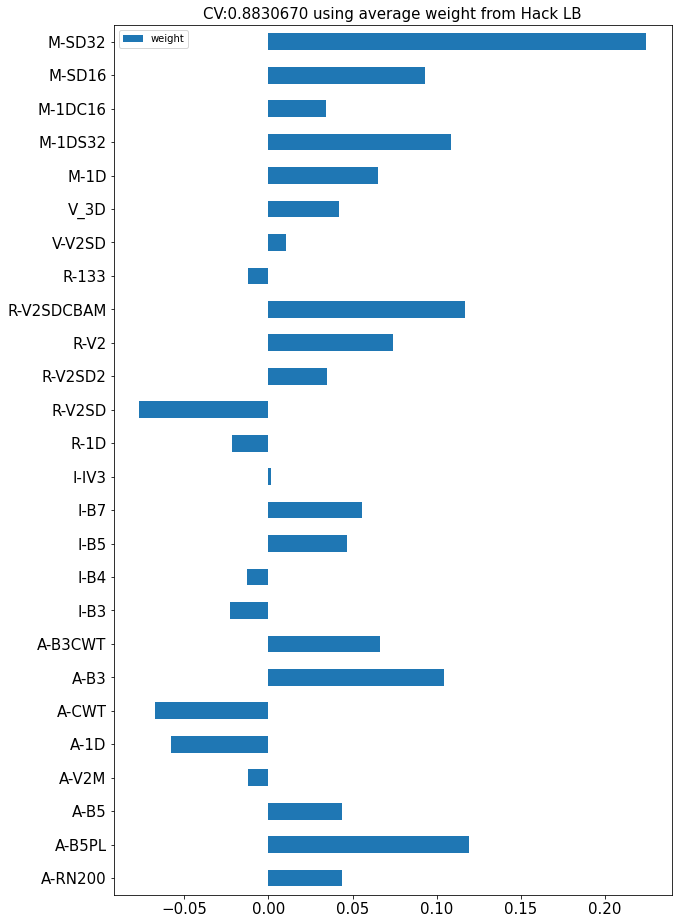

In [105]:
if use_hack:
    cma_opt_preds=oof_df.copy()
    X = oof_df.iloc[:,3:].values
    def get_score(weights, oof):
        weights = np.array(weights)
        oof["prediction"] = (weights * X).sum(axis=1)
        return -score_oof_fast(oof)
    
    ws = np.mean(np.array(wss),axis=0)
    cma_cv_score = -get_score(ws, cma_opt_preds)
    plot_weight(cma_opt_preds.columns[3:], ws, f"CV:{cma_cv_score:.7f} using average weight from Hack LB")

In [106]:
# if use_hack:
#     low_diff_scores = sorted([abs(0.8840-s) for s in scores])[:num_hack]
#     drop_ids_selected = [drop_ids[i] for i,s in enumerate(scores) if abs(0.8840-s) in low_diff_scores]
#     for i in range(len(drop_ids_selected)):
#         drop_id = drop_ids_selected[i]
#         oof_df_hack = oof_df.query(f"id not in {list(drop_id)}").copy()
#         X = oof_df_hack.iloc[:,3:].values
#         def get_score(weights, oof):
#             weights = np.array(weights)
#             oof["prediction"] = (weights * X).sum(axis=1)
#             return -score_oof_fast(oof)

#         original_ws = wss[i]
#         cma_cv_score_averaged = -get_score(ws, oof_df_hack)
#         cma_cv_score_original = -get_score(original_ws, oof_df_hack)
#         cma_cv_score_all = -get_score(cv_weight, oof_df_hack)
#         print(f"After using averaged weight, LB CV:{cma_cv_score_original:.7f} ----> {cma_cv_score_averaged:.7f} , changes : {(cma_cv_score_averaged-cma_cv_score_original) * 1e4:.3f} bps")
#         print(f"If we use the weights from all data CV: {cma_cv_score_all:.7f}, changes {(cma_cv_score_all-cma_cv_score_original) * 1e4:.3f} bps")

In [107]:
model_cols = oof_df.columns[3:]

In [108]:
cma_opt_preds["prediction"] = np.sum(ws * cma_opt_preds[model_cols],axis=1)
cma_opt_preds[["id","target","fold","prediction"]].to_csv(data_folder + f"/oof_pred_cma_CV{cma_cv_score:.5f}.csv",index=False)

In [109]:
cma_opt_preds.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['prediction']))

fold
0    0.883599
1    0.882456
2    0.882290
3    0.884191
4    0.882801
dtype: float64

In [110]:
cma_opt_preds.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['prediction'])).mean()

0.8830672796177254

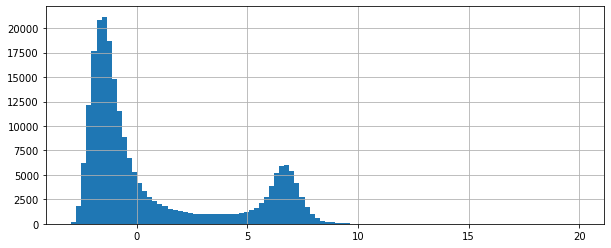

CMAEvolutionStrategyResult(xbest=array([ 5.62271005, 14.52001314,  5.63644471, -0.7897137 , -6.62289834,
       -7.2769071 ,  9.61428317,  6.54873873, -1.87046945, -1.62320799,
        3.63919598,  6.08542989, -0.18915628, -1.20480381, -9.80597653,
        3.89025561,  9.33032971, 13.75271298, -1.54665568,  0.71727328,
        4.16867433,  6.94192798, 11.55149592,  5.72044347,  8.83948252,
       23.23344038]), fbest=-0.882836, evals_best=1104, evaluations=1300, iterations=100, xfavorite=array([ 5.64607529, 14.99027191,  5.39373208, -2.26064735, -6.48734345,
       -6.95757491, 10.63471148,  6.44177811, -1.74796045, -1.30923823,
        3.52133339,  6.40308976, -0.32624965, -1.34767206, -9.82884139,
        4.1077368 ,  8.98231623, 14.2679933 , -0.77891521,  0.60882251,
        3.81163565,  7.09014525, 11.5914568 ,  6.32695894,  9.54270915,
       24.40658441]), stds=array([0.32134646, 0.3851019 , 0.31498758, 0.29896935, 0.27996739,
       0.30464937, 0.37414094, 0.32575829, 0.29688215

Optimised Blend OOF: 0.882836
Index(['A-RN200', 'A-B5PL', 'A-B5', 'A-V2M', 'A-1D', 'A-CWT', 'A-B3',
       'A-B3CWT', 'I-B3', 'I-B4', 'I-B5', 'I-B7', 'I-IV3', 'R-1D', 'R-V2SD',
       'R-V2SD2', 'R-V2', 'R-V2SDCBAM', 'R-133', 'V-V2SD', 'V_3D', 'M-1D',
       'M-1DS32', 'M-1DC16', 'M-SD16', 'M-SD32'],
      dtype='object') (470400, 29)
Inital Blend OOF: 0.882390
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 26 (seed=2021, Wed Sep 29 18:02:24 2021)
termination on tolflatfitness=1
final/bestever f-value = -8.828310e-01 -8.828320e-01
incumbent solution: [ 3.67197513  7.6621188   4.57167246 -0.25996948 -4.59127908 -5.70358983
 11.03069996  6.9705218  ...]
std deviations: [0.24000509 0.27767143 0.24163074 0.24916433 0.23347364 0.25541571
 0.27629928 0.24530556 ...]
CMAEvolutionStrategyResult(xbest=array([ 3.82806519,  7.42646707,  4.56195329, -0.24072369, -4.55378649,
       -6.13643041, 11.00386594,  7.23927977, -3.19377707, -0.2859223 ,
        5.321818  ,  5.10237458, -0.87381881, -3.6

In [111]:
sub_cma = sub_df[['id']].copy()
sub_cma['target'] = np.sum(sub_df.iloc[:,1:] * ws,axis=1)
sub_cma.to_csv(data_folder + f"/cma_ensemble_{cma_cv_score:0.5f}.csv", index=False)
sub_cma["target"].hist(bins=100,figsize=(10,4));

# Add Distill5c

In [ ]:
# import glob
# csv_files = glob.glob("../input/ensemble-0916/*.csv")
# test_df = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
# abbrs = [file.split("/")[-1].split(".")[0] for file in csv_files if "oof" not in file]
# for file in csv_files:   
#     if file=="../input/ensemble-0916/distill5c_submission_rank_8805.csv":
#         print(file)
#         tmp = pd.read_csv(file)
#         tmp.rename(columns={"target":file.split("/")[-1].split(".")[0]},inplace=True)
#         test_df = test_df.merge(tmp,on="id",how="left")

In [ ]:
# test_df = test_df.merge(sub_cma[['id','target']].rename(columns={"target":"cma_opt"}),on="id")
# test_df

In [ ]:
# test_df.iloc[:,2:].plot(kind="hist",bins=100,figsize=(16,8),alpha=0.5)
# plt.legend(loc='upper right');

In [ ]:
# test_df["cma_opt"].hist(bins=100,figsize=(10,4));

In [ ]:
# test_df['distill5c_submission_rank_8805'] = test_df['distill5c_submission_rank_8805'].rank(pct=True)
# test_df['cma_opt'] = test_df['cma_opt'].rank(pct=True)
# col_weight_dict = {
#     "cma_opt" : 0.95,
#     "distill5c_submission_rank_8805" : 0.05,
# }

In [ ]:
# sub_df = test_df[["id"]].copy()
# sub_df["target"] = 0
# for col, weight in col_weight_dict.items():
#     sub_df["target"] += (test_df[col]**2) * weight

In [ ]:
# sub_df["target"].hist(bins=100,figsize=(10,4))

In [ ]:
# sub_df[['id','target']].to_csv("sub_aggressive.csv", index=False)

# HillClimb
- https://www.kaggle.com/cdeotte/forward-selection-oof-ensemble-0-942-private/

In [ ]:
# x = np.zeros(( oof_df.shape[0], oof_df.shape[1] -3 ))
# for i,col in enumerate(oof_df.columns[3:]):
#     x[:,i] = oof_df[col].values
# TRUE = oof_df['target'].values
# all_auc = []
# for i in range(x.shape[1]):
#     auc = roc_auc_score(TRUE,x[:,i])
#     all_auc.append(auc)
#     print('Model %i has OOF AUC = %.4f'%(i,auc))

In [ ]:
# m = [np.argmax(all_auc)]; w = []
# m

In [ ]:
# old = np.max(all_auc); 
# RES = 200; 
# PATIENCE = RES//10; 
# TOL = 0.00005 # 0.5 bps
# DUPLICATES = False

# print('Ensemble AUC = %.5f by beginning with model %i'%(old,m[0]))
# print()

# for kk in range(x.shape[1]):
    
#     # BUILD CURRENT ENSEMBLE
#     md = x[:,m[0]]
#     for i,k in enumerate(m[1:]):
#         md = w[i]*x[:,k] + (1-w[i])*md
        
#     # FIND MODEL TO ADD
#     mx = 0; mx_k = 0; mx_w = 0
#     print('Searching for best model to add... ')
    
#     # TRY ADDING EACH MODEL
#     for k in range(x.shape[1]):
#         print(k,', ',end='')
#         if not DUPLICATES and (k in m): continue
            
#         # EVALUATE ADDING MODEL K WITH WEIGHTS W
#         bst_j = 0; bst = 0; ct = 0
#         for j in range(RES):
#             tmp = j/RES*x[:,k] + (1-j/RES)*md
#             auc = roc_auc_score(TRUE,tmp)
#             if auc>bst:
#                 bst = auc
#                 bst_j = j/RES
#             else: ct += 1
#             if ct>PATIENCE: break
#         if bst>mx:
#             mx = bst
#             mx_k = k
#             mx_w = bst_j
            
#     # STOP IF INCREASE IS LESS THAN TOL
#     inc = mx-old
#     if inc<=TOL: 
#         print(); print('No increase. Stopping.')
#         break
        
#     # DISPLAY RESULTS
#     print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
#     print('Ensemble AUC = %.5f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
#     print()
    
#     old = mx; m.append(mx_k); w.append(mx_w)

In [ ]:
# print('We are using models',m)
# print('with weights',w)
# print('and achieve ensemble AUC = %.5f'%old)

In [ ]:
# md = x[:,m[0]]
# for i,k in enumerate(m[1:]):
#     md = w[i]*x[:,k] + (1-w[i])*md
# plt.hist(md,bins=100)
# plt.title('Ensemble OOF predictions')
# plt.show()

In [ ]:
# md2 = sub_df.loc[:,f"sub-{m[0]}"]
# for i,k in enumerate(m[1:]):
#     md2 = w[i]* sub_df.loc[:,f"sub-{k}"] + (1-w[i])*md2
# plt.hist(md2,bins=100)
# plt.show()

In [ ]:
# sub_hillClimb = sub_df[['id']].copy()
# sub_hillClimb['target'] = md2
# sub_hillClimb["target"].hist(bins=100,figsize=(10,4))
# sub_hillClimb.to_csv(f"./hillClimb_{score_oof(sum_preds):0.5f}.csv", index=False)

# Optuna Optimzation Weight

In [ ]:
import optuna
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
optuna.logging.set_verbosity(optuna.logging.ERROR)

class GeneralizedMeanBlender():
    """Combines multiple predictions"""
    def __init__(self, p_range=(0,10)):
        """"""
        self.p_range = p_range
        self.p = None
        self.weights = None
                
    def _objective(self, trial, X, oof_opt_df):           
        # create hyperparameters
        weights = [
            trial.suggest_uniform(f"w{i}", -1, 1)
            for i in range(X.shape[1])
        ]
        # blend predictions
        blend_preds, total_weight = 0, 0
        for j,w in enumerate(weights):
            blend_preds += w*X[:,j]
            total_weight += w
        blend_preds = blend_preds/total_weight
        oof_opt_df["prediction"] = blend_preds
        
        return - score_oof(oof_opt_df,col='prediction')

    def fit(self, X, oof_opt_df, n_trials=10): 
        # optimize objective
        obj = partial(self._objective, X=X, oof_opt_df=oof_opt_df)
        study = optuna.create_study()
        study.optimize(obj, n_trials=n_trials)
        # extract best weights
        self.weights = np.array([v for k,v in study.best_params.items() if "w" in k])
        self.weights /= self.weights.sum()

    def transform(self, X): 
        assert self.weights is not None
        return np.dot(X, self.weights)
    
    def fit_transform(self, X, oof_opt_df, **kwargs):
        self.fit(X, oof_opt_df, **kwargs)
        return self.transform(X)

In [ ]:
# oof_opt_df = oof_df[["id","target","fold"]].copy()
# model_cols = oof_df.columns[3:]
# X_oof = oof_df.iloc[:,3:].values
# X_sub = sub_df.iloc[:,1:].values

In [ ]:
# %%time
# n_trial = 2000
# gmb = GeneralizedMeanBlender()
# X_oof_sum = gmb.fit_transform(X_oof, oof_opt_df, n_trials=n_trial)
# oof_opt_df['prediction'] = X_oof_sum
# print(f"AUC= {score_oof(oof_opt_df,col='prediction')}")
# pd.DataFrame(dict(zip(model_cols,gmb.weights)),index=["weight"]).T.plot(kind="barh")

In [ ]:
# X_sub_sum = gmb.transform(X_sub)

In [ ]:
# sns.distplot(X_sub_sum)

In [ ]:
# sub_optuna = sub_df[['id']].copy()
# sub_optuna['target'] = X_sub_sum
# sub_optuna.to_csv(f"./optuna_ensemble_{score_oof(oof_opt_df,col='prediction'):0.5f}.csv", index=False)
# sub_optuna["target"].hist(bins=100,figsize=(10,4));

# Optimized Weighted Power Mean

In [ ]:
# import optuna
# import os
# import optuna
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from functools import partial

# class GeneralizedMeanBlender():
#     """Combines multiple predictions"""
#     def __init__(self, p_range=(1,4)):
#         """"""
#         self.p_range = p_range
#         self.p = None
#         self.weights = None
        
#     def _objective(self, trial, X, oof_opt_df):           
#         # create hyperparameters
#         p = trial.suggest_uniform(f"p", *self.p_range)
#         weights = [
#             trial.suggest_uniform(f"w{i}", -1, 1)
#             for i in range(X.shape[1])
#         ]
#         # blend predictions
#         blend_preds, total_weight = 0, 0
#         for j,w in enumerate(weights):
#             blend_preds += w*X[:,j]**p
#             total_weight += w
#         blend_preds = blend_preds/total_weight
#         oof_opt_df["prediction"] = blend_preds
        
#         return - score_oof(oof_opt_df,col='prediction')

#     def fit(self, X, oof_opt_df, n_trials=10): 
#         # optimize objective
#         obj = partial(self._objective, X=X, oof_opt_df=oof_opt_df)
#         study = optuna.create_study()
#         study.optimize(obj, n_trials=n_trials)
#         # extract best weights
#         if self.p is None:
#             self.p = [v for k,v in study.best_params.items() if "p" in k][0]
#         self.weights = np.array([v for k,v in study.best_params.items() if "w" in k])
#         self.weights /= self.weights.sum()

#     def transform(self, X): 
#         assert self.weights is not None and self.p is not None,\
#         "Must call fit method before transform"
#         return np.dot(X**self.p, self.weights)
    
#     def fit_transform(self, X, oof_opt_df, **kwargs):
#         self.fit(X, oof_opt_df, **kwargs)
#         return self.transform(X)

In [ ]:
# oof_opt_df = oof_df[["id","target","fold"]].copy()
# model_cols = oof_df.columns[3:]
# X_oof = oof_df.iloc[:,3:].values
# X_sub = sub_df.iloc[:,1:].values

In [ ]:
# %%time
# n_trial = 100
# gmb = GeneralizedMeanBlender()
# X_oof_sum = gmb.fit_transform(X_oof, oof_opt_df, n_trials=n_trial)
# oof_opt_df['prediction'] = X_oof_sum
# print(f"AUC= {score_oof(oof_opt_df,col='prediction')}")
# print(f"optimized power: {gmb.p:.4f}")
# pd.DataFrame(dict(zip(model_cols,gmb.weights)),index=["weight"]).T.plot(kind="barh", figsize=(10,16))

In [ ]:
# X_sub_sum = gmb.transform(X_sub)

In [ ]:
# sns.distplot(X_sub_sum)

In [ ]:
# sub_optuna = sub_df[['id']].copy()
# sub_optuna['target'] = X_sub_sum
# sub_optuna.to_csv(f"./optuna_ensemble_{score_oof(oof_opt_df,col='prediction'):0.5f}.csv", index=False)
# sub_optuna["target"].hist(bins=100,figsize=(10,4));